In [51]:
# mount content from drive
from google.colab import drive
import glob
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import imutils
import math

#authorize google sheets
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Import modules
import sys, dlib, time
# import faceBlendCommon as fbc
# Set the path to your project folder
pDir = '/content/drive/My Drive/ColabNotebooks/'

In [54]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


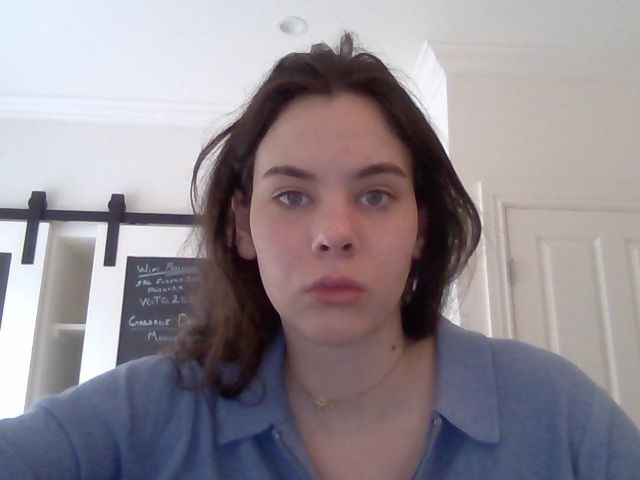

In [74]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [75]:
#correct and show image temporarily
#img = cv2.imread(pDir+'finalResources/zep.jpg')
img = cv2.imread(filename)
# The important part - Correct BGR to RGB channel
imgdisp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



In [76]:
# Initialize the dlib facial landmark detector
detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor(pDir+"finalResources/shape_predictor_68_face_landmarks.dat")
# Read array of corresponding points
points = fbc.getLandmarks(detector, predictor, img)

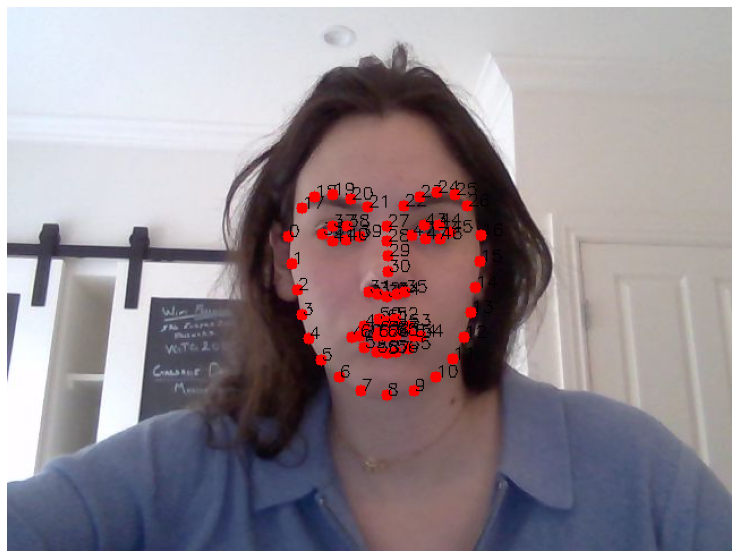

In [77]:
imTemp = imgdisp.copy()
i = 0;
for p in points:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)
    #display index of dot for later reference. 
    cv2.putText( imTemp, str(i), p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0, 0), 1) 
    i = i+1; 
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [78]:
#uses pythagorean theory to find the distance between two tuples 
def getDist(p1,p2): 
  xdif = abs(p1[0]-p2[0]);
  ydif = abs(p1[1]-p2[1]);
  return math.sqrt(xdif^2+ydif^2)

In [79]:
def normalize(measurement,face_width): #normalize the facial distances with repect to a given measurment 
  measurement[:] = [int(x*100/face_width) for x in measurement]
  return measurement


In [80]:
def getNormalizedDistances(points):
  #calculate user distances . 
  between_nostrils = getDist(points[35],points[31])
  nose_height = getDist(points[27],points[30])
  eye_width = (getDist(points[45],points[42])+getDist(points[39],points[36]))/2
  eye_height = (getDist(points[38],points[40])+getDist(points[44],points[43]))/2
  between_eyes = getDist(points[39],points[42])
  mouth_width = getDist(points[48],points[64])
  mouth_height = getDist(points[52],points[57])
  face_width = getDist(points[0],points[16])
  face_height = getDist(points[8],points[16])

  user = {
      'name': 2,
      'measurements': [between_nostrils, nose_height, eye_width, eye_height, between_eyes, mouth_width, mouth_height, face_width, face_height, 0]
  }

  user['measurements'] = normalize(user['measurements'],face_width)
  print(user)
  return user; 

In [81]:
#create user data
user = getNormalizedDistances(points)

#import google slides of data to compare 
worksheet = gc.open('DinosaurMeasurements').sheet1
dinosaurs = []

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
nameingIndex = rows.pop(0)

#normalize dinosaur data
for dino in rows: 
  name = dino.pop(0)
  dino[:] = [float(x) for x in dino]
  dinosaurs.append(
      {
          'name': name,
          'measurements': normalize(dino,dino[7])
      }
  )


{'name': 2, 'measurements': [43, 48, 47, 27, 52, 56, 49, 100, 113, 0]}


In [82]:
import difflib
from difflib import SequenceMatcher

#get ya dinosaur 
justMeasurements = []
userMeausrements = np.array(user['measurements'])
measurementSums = []
for dino in dinosaurs:
  justMeasurements.append(sum(np.array(dino['measurements'])-userMeausrements))

minIndex = justMeasurements.index(min(justMeasurements))
print(dinosaurs[minIndex]['name'])



mookie


In [83]:
# upload all user faces and create arrays sorting them based on distances 
detector_f = dlib.get_frontal_face_detector()
predictor_f = dlib.shape_predictor(pDir+"finalResources/shape_predictor_68_face_landmarks.dat")

faces=[]; 
standardMes = [[],[],[],[],[],[],[],[],[],[]]

for filename in os.listdir(pDir+'finalResources/faceArchive'):
    if filename.endswith("jpg"): 
        faces.append(filename)
        img_f = cv2.imread(pDir+'finalResources/faceArchive/'+filename)
        img_f = cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB)
        points = fbc.getLandmarks(detector_f, predictor_f, img_f)
        tempUser = getNormalizedDistances(points)
        for i in range(0,10):
            standardMes[i].append(tempUser['measurements'][i])

for element in standardMes:
  element.sort()

print(standardMes)

{'name': 2, 'measurements': [50, 55, 42, 28, 55, 63, 52, 100, 111, 0]}
{'name': 2, 'measurements': [43, 51, 40, 24, 53, 59, 46, 100, 97, 0]}
{'name': 2, 'measurements': [39, 52, 39, 27, 44, 51, 37, 100, 81, 0]}
{'name': 2, 'measurements': [43, 58, 48, 28, 53, 56, 35, 100, 116, 0]}
{'name': 2, 'measurements': [38, 56, 43, 28, 53, 54, 46, 100, 99, 0]}
{'name': 2, 'measurements': [37, 52, 45, 28, 50, 53, 41, 100, 106, 0]}
{'name': 2, 'measurements': [42, 54, 43, 25, 50, 55, 29, 100, 112, 0]}
{'name': 2, 'measurements': [40, 50, 40, 26, 51, 59, 42, 99, 60, 0]}
{'name': 2, 'measurements': [43, 54, 45, 26, 50, 58, 41, 100, 107, 0]}
{'name': 2, 'measurements': [42, 54, 45, 25, 49, 56, 37, 100, 71, 0]}
{'name': 2, 'measurements': [47, 57, 45, 26, 55, 63, 30, 100, 119, 0]}
{'name': 2, 'measurements': [40, 53, 43, 21, 46, 52, 22, 99, 50, 0]}
{'name': 2, 'measurements': [44, 50, 44, 25, 52, 61, 26, 100, 52, 0]}
{'name': 2, 'measurements': [48, 59, 41, 26, 50, 61, 39, 100, 116, 0]}
{'name': 2, 'me

In [84]:
#organize the dinosaurs via their measurments for each different measurement

standardMesDinos = [[],[],[],[],[],[],[],[],[],[]]

for dino in dinosaurs:       
   for i in range(0,10):
      standardMesDinos[i].append({
          'name': dino['name'],
          'measurement': dino['measurements'][i]
      })

for i in range(0,10):
  standardMesDinos[i] = sorted(standardMesDinos[i], key=lambda k: k['measurement']) 


In [85]:
# find where user falls within larger facial dataset 
userIndexes = [];  
for i in range(0,10): 
  currentMeasurement = user['measurements'][i]
  indexInCompositeMeasurements = 0
  while(indexInCompositeMeasurements < len(standardMes[i]) and currentMeasurement > standardMes[i][indexInCompositeMeasurements]):
    indexInCompositeMeasurements += 1
  userIndexes.append(indexInCompositeMeasurements)

#find the number of divisions  and scale the user indexes
numDivisions = math.ceil(len(standardMes[0])/(len(dinosaurs)))
userIndexes[:] = [int(math.floor(x / numDivisions)) for x in userIndexes]
print(userIndexes)
#convert the index to the dinosaur at that index 
for i in range(0,10):
  print(i)
 # if userIndexes[i] < len(dinosaurs):
  userIndexes[i] = standardMesDinos[i][userIndexes[i]]['name']
#need to ignore a couple of unimplimented indexes

userIndexes[9] = 'x'
userIndexes[7] = 'y'
print(userIndexes)
matchedDionsaur = max(set(userIndexes), key = userIndexes.count)
print(matchedDionsaur)


[2, 0, 6, 4, 2, 2, 6, 0, 6, 0]
0
1
2
3
4
5
6
7
8
9
['Dennis ', 'Dennis ', 'Buddy', 'mr. petradon', 'mookie', 'Dennis ', 'Buddy', 'y', 'Buddy', 'x']
Buddy


/content/drive/My Drive/ColabNotebooks/finalResources/dinosaurs/Buddy.jpg


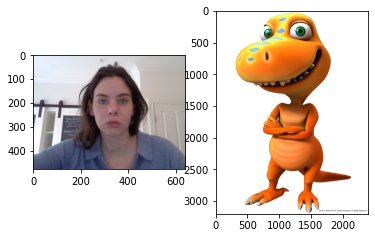

In [86]:
img2 = cv2.imread(pDir+ 'finalResources/dinosaurs/'+matchedDionsaur+'.jpg');
if(matchedDionsaur != 'x'):
  print(pDir+'finalResources/dinosaurs/'+matchedDionsaur+'.jpg')  
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(imgdisp);
  ax[1].imshow(img2);
else: 
  print("congrats, you matched with everyone equally. you are an equal split of all dinosaurs")